# Ансамблирование алгоритмов
### AI Community: Практический курс по машинному обучению
#### Материалы подготовлены EORA Data Lab

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

np.random.seed(42)
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Считаем данные: это показатели качества сотрудников некоторой компании. Построим модель, которая предсказывает уход сотрудника.

In [2]:
df = pd.read_csv('data/HR.csv')
print(df.shape)
df.head()

(14999, 7)


,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
0,0.53,2,157,3,0,1,0
1,0.86,5,262,6,0,0,0
2,0.88,7,272,4,0,1,0
3,0.87,5,223,5,0,1,0
4,0.52,2,159,3,0,1,0


In [3]:
target = 'left'
features = df.columns.drop(target)
print(features)

X, y = df[features], df[target]

Index(['last_evaluation', 'number_project', 'average_montly_hours',
       'time_spend_company', 'Work_accident', 'promotion_last_5years'],
      dtype='object')


В дальнейшем будем оценивать качество модели на кросс-валидации на 5 фолдах при помощи точности (accuracy).

In [4]:
def estimate_accuracy(clf, X, y, cv=5):
    return cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()

Посмотрим на то, как работает бэггинг над решающими деревьями.  
__Бэггинг__ (bagging, bootstrap aggregating) $-$ метод построения композиции алгоритмов, в котором каждый алгоритм строится независимо от других на подвыборках обучающей выборки. Итоговый алгоритм принимает решения посредством голосования среди всех алгоритмов (возвращается самый частый ответ).

Посмотрим на точность одного дерева.

In [5]:
tree = DecisionTreeClassifier(max_depth=8)
print("Decision tree:", estimate_accuracy(tree, X, y))

Decision tree: 0.76744912748694


Проведем бэггинг: для этого достаточно обернуть исходный классификатор в `BaggingClassifier`.

In [6]:
bagging_trees = BaggingClassifier(
    tree,
    max_features=3)
print("Decision tree bagging:", estimate_accuracy(bagging_trees, X, y))

Decision tree bagging: 0.7753185061687229


Композиция отдельных деревьев показывает себя лучше чем одно дерево. Структура дерева сильно зависит от обучающей выборки, а значит что, если немного изменить обучающую выборку, то дерево сильно изменится. Бэггинг идеально подходит в этом случае, поскольку композиция алгоритмов при помощи голосования работает наилучшим образом, когда модели различны.

Увеличить различность построенных деревьев можно указав параметры `max_features` и `max_depth`.

In [7]:
random_tree = DecisionTreeClassifier(max_features=int(np.sqrt(len(features))), max_depth=8)
print("Random tree:", estimate_accuracy(random_tree, X, y))

Random tree: 0.7647841725019451


In [8]:
bagging_random_trees = BaggingClassifier(random_tree)
print("Random tree bagging:", estimate_accuracy(bagging_random_trees, X, y))

Random tree bagging: 0.7779175058352784


Именно так внутри и работает так называемый __случайный лес__ (Random Forest): он обучает набор деревьев (параметр `n_esimators`), каждое из которых обучается на подмножестве признаков (Random Subspaces) и на подмножестве объектов (bootstrap). Получается, что случайный лес случаен и по признакам, и по объектам. Ответы каждого дерева аггрегируются при помощи голосования.  
Стандартная эвристика: в задаче классификации брать квадратный корень числа признаков, а в задаче регрессии треть числа признаков.

In [9]:
random_forest = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    oob_score=True,
    max_features=int(np.sqrt(len(features))),
    max_depth=8)
print("Random Forest:", estimate_accuracy(random_forest, X, y))

Random Forest: 0.7801847504723797


Еще одно преимущество использования бэггинга для аггрегации моделей: получение оценки работы классификатора без дополнительного проведения кросс-валидации при помощи out-of-bag score.
__Out-of-bag score__ (OOB) $-$ это метод вычисления произвольной оценки качества во время обучения бэггинга. Для этого обученный на подвыборке алгоритм оценивается на тех примерах из всей обучающей выборки, который не попали в подвыборку.  
Для подсчета OOB требуется указать параметр `oob_score = True`. Его имеет смысл указать при достаточном количестве деревьев, иначе выдается ошибка.

In [10]:
random_forest = RandomForestClassifier(
    n_estimators=50,
    max_features=int(np.sqrt(len(features))),
    max_depth=8,
    oob_score=True
)
random_forest.fit(X, y)
random_forest.oob_score_.mean()

0.785385692379492

Метод бэггинга можно применять к произвольным алгоритмам, например к логистической регрессии.

In [11]:
lr = LogisticRegression(C=10)
lr.fit(X, y)
print("LR:", estimate_accuracy(lr, X, y))

LR: 0.6318360786928976


In [12]:
np.abs(lr.coef_).max()

0.5756311849167438

In [13]:
random_logreg = BaggingClassifier(
    lr,
    max_features=3,
    n_estimators=50,
    n_jobs=-1,
)
print("Bagging for LR:", estimate_accuracy(random_logreg, X, y))

Bagging for LR: 0.6431731243747916


В ее случае он не так сильно повышает качество, поскольку линейные модели не так сильно зависят от состава обучающей выборки.  
Однако, можно улучшить качество композиции, убрав часть признаков.

In [14]:
random_logreg = BaggingClassifier(
    lr,
    n_estimators=16,
    n_jobs=-1,
    max_features=int(np.sqrt(len(features)))
)
print("Bagging for LR:", estimate_accuracy(random_logreg, X, y))

Bagging for LR: 0.6547769923307769


А теперь рассмотрим алгоритм AdaBoost. Основное его отличие от алгоритма Bagging заключается в том, что он строит сложный классификатор из последовательный предсказаний простых классификаторов. В качестве алгоритма по-умолчанию используется "решающий пень" - решающее дерево глубины 1.

In [19]:
boost_tree = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=50, 
    learning_rate=1
)
print("Bagging for LR:", estimate_accuracy(boost_tree, X, y))

Bagging for LR: 0.7423157052350783


В качестве слабых классификатором можно также использовать любой алгоритм, в том числе логистическую регрессию. 

In [21]:
boost_logreg = AdaBoostClassifier(
    lr,
    n_estimators=50, 
    learning_rate=1
)
print("Bagging for LR:", estimate_accuracy(boost_logreg, X, y))

Bagging for LR: 0.6315693008780705


### Перебор параметров по сетке

In [22]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [24]:
cv = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions={
        'max_depth': [3, 5, None],
        'n_estimators': [10, 50, 100]
    },
    cv=3, verbose=True,
    scoring='roc_auc'
)

In [25]:
cv.fit(X, y)

D:\Vyacheslav\Anaconda\envs\training_pipeline\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    4.5s finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, None],
                                        'n_estimators': [10, 50, 100]},
                   scoring='roc_auc', verbose=True)

In [26]:
cv.best_estimator_

RandomForestClassifier(max_depth=5, n_estimators=10)

### Сравнение логистической регрессии и случайного леса

In [27]:
def plot_predictions(X, y, clf, proba=False, points_size=7, xlabel='x', ylabel='y'):
    """Fits the classifier on the data (X, y) and plots the result on a 2-D plane."""
    def get_grid(data):
        x_std, y_std = data.std(axis=0)
        x_min, x_max = data[:, 0].min() - x_std / 2, data[:, 0].max() + x_std / 2
        y_min, y_max = data[:, 1].min() - y_std / 2, data[:, 1].max() + y_std / 2
        return np.meshgrid(np.linspace(x_min, x_max, num=200),
                           np.linspace(y_min, y_max, num=200))
    
    clf.fit(X, y)
    xx, yy = get_grid(X)
    if proba:
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
    plt.figure(figsize=(10.0, 10.0))
    plt.pcolormesh(xx, yy, predicted, cmap=plt.cm.coolwarm, alpha=0.1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=points_size, cmap=plt.cm.coolwarm, alpha=0.90)
    plt.ylim([yy.min(),yy.max()])
    plt.xlim([xx.min(),xx.max()])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    return clf

D:\Vyacheslav\Anaconda\envs\training_pipeline\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


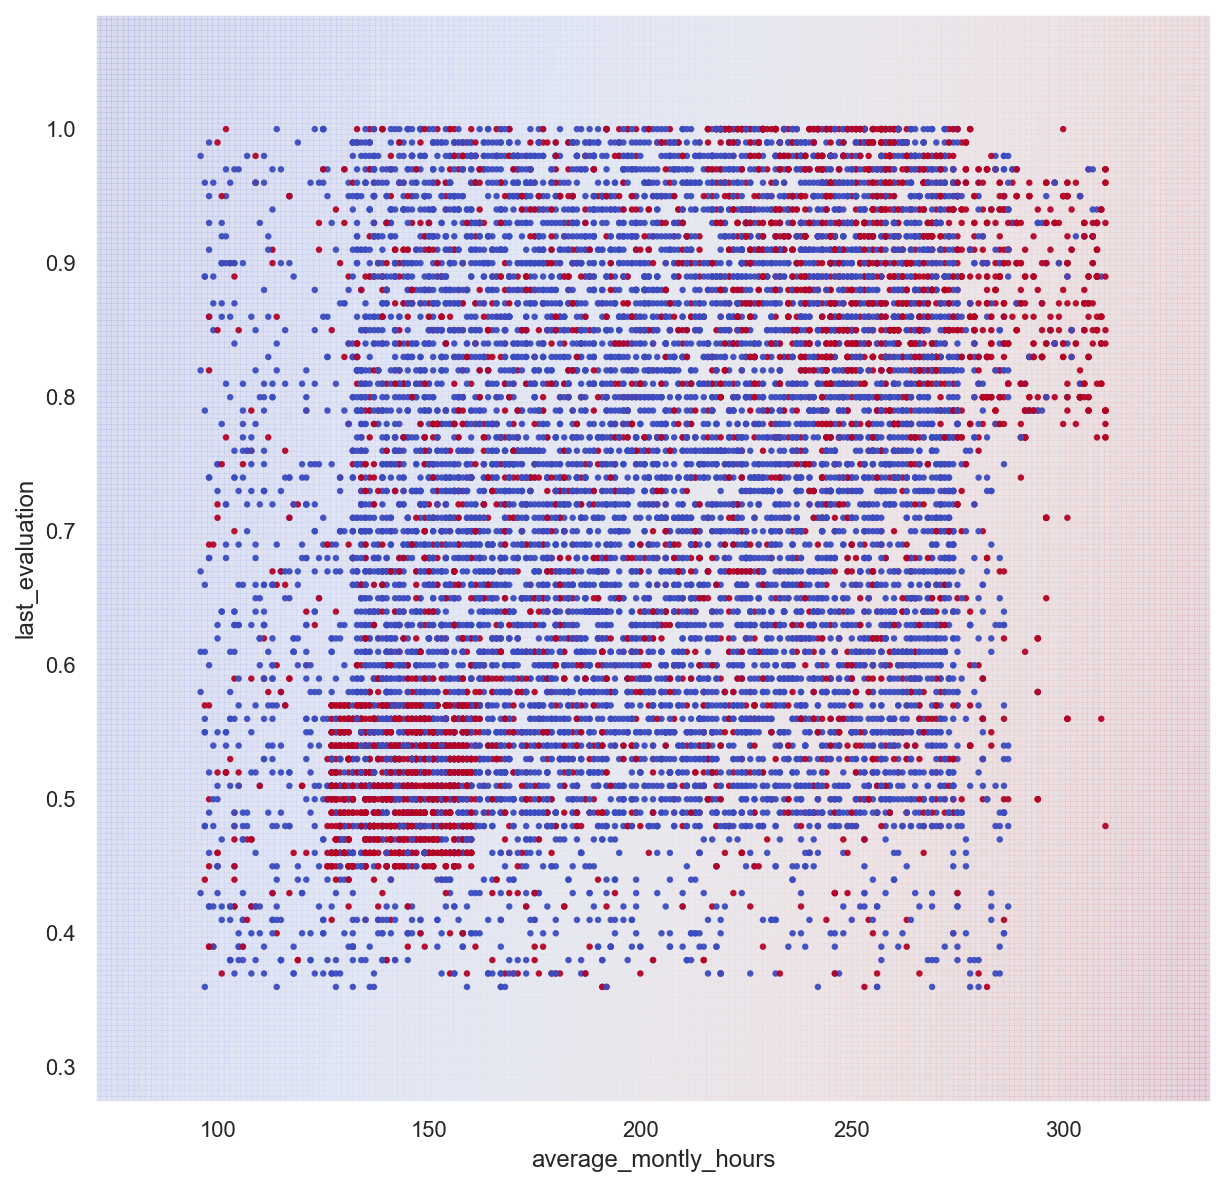

In [28]:
plot_predictions(X[['average_montly_hours', 'last_evaluation']].values, y,
                 LogisticRegression(),
                 points_size=5,
                 proba=True, xlabel='average_montly_hours', ylabel='last_evaluation');

D:\Vyacheslav\Anaconda\envs\training_pipeline\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


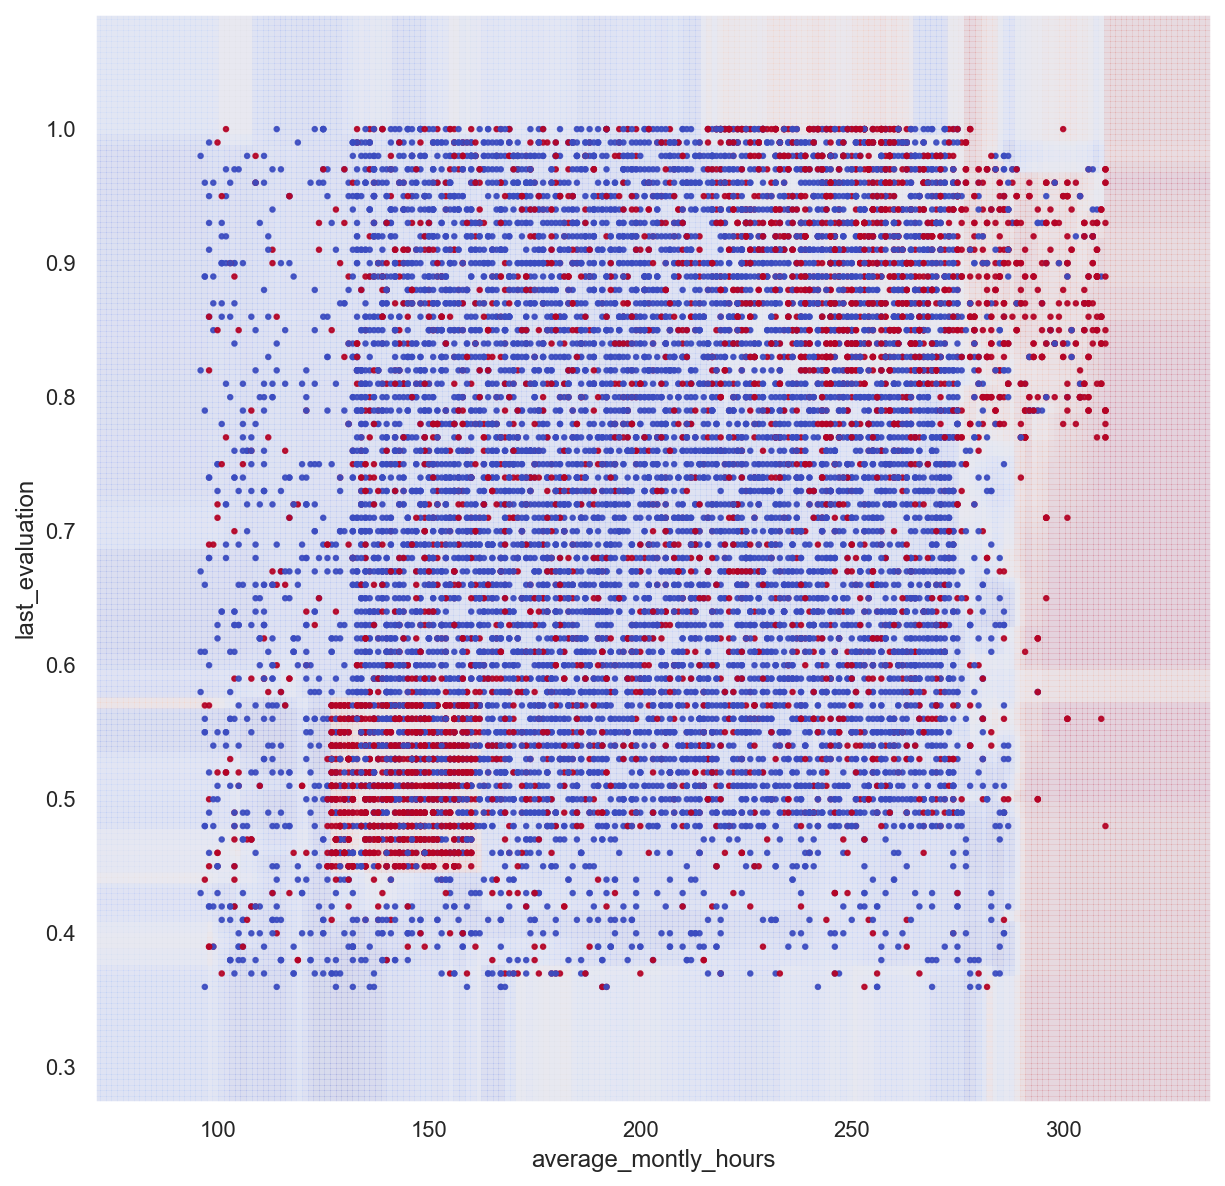

In [29]:
plot_predictions(X[['average_montly_hours', 'last_evaluation']].values, y,
                 RandomForestClassifier(
                     n_estimators=50,
                     max_features=2,
                     max_depth=8),
                 points_size=5,
                 proba=True, xlabel='average_montly_hours', ylabel='last_evaluation');

Дополнительная литература:
* Изменение качества случайного леса в зависимости от числа деревьев: http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html